# Stem Cell Model

From Brady et al.

In [4]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


sys.path.append("../utils")
from odeModels import StemCellModel, StemCellModel2
from plotUtils import PlotSimulation


In [5]:
# Defaults for plotting
plt.style.use(["classic", "../utils/paper.mplstyle"])
plt.rcParams['font.size'] = '18'

colors = {'Sensitive': '#4c9150', 'Resistant': '#a80303', 'CT':'#c28d32' , 'AT':'#143159' ,'DRL_Monthly':'#66419e'}

## Model Simulations

In [6]:
# Patient 1002 - TTP ~ 3000 days
stemParamDic2 = {'rR': np.log(2),'beta': 0.025, 'dR': 0.4852,  # Cell params
                'rho': 0.0025, 'phi': 0.0167, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 58.57}  # Initial conditions
# Patient 1005 - TTP ~ 3000 days
stemParamDic5 = {'rR': np.log(2),'beta': 0.0276, 'dR': 0.3205,  # Cell params
                'rho': 0.0016, 'phi': 0.0068, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 95.86}  # Initial conditions
# Patient 1010 - TTP ~ 300 days
stemParamDic10 = {'rR': np.log(2),'beta': 0.3332, 'dR': 0.0958,  # Cell params
                'rho': 6.548e-5, 'phi': 0.0028, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 17.33}  # Initial conditions
# Patient 1014 - TTP ~ 2000 days
stemParamDic14 = {'rR': np.log(2),'beta': 0.0425, 'dR': 0.0478,  # Cell params
                'rho': 1.243e-04, 'phi': 0.0113, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 11.83}  # Initial conditions
# Patient 1018 - TTP ~ 800 days
stemParamDic18 = {'rR': np.log(2),'beta': 0.1208, 'dR': 0.2083,  # Cell params
                'rho': 4.931e-04, 'phi': 0.0149, 'DMax': 1,  # PSA/Drug params
                'S0': 1000, 'R0': 10, 'P0': 36.54}  # Initial conditions

Mean TTP for Stem Cell Model under Continuous Therapy is 1099 days


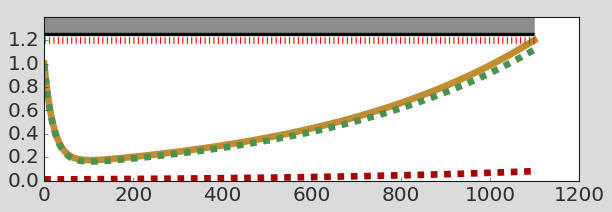

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
stemParamDic['P0'] = 0; stemParamDic['rho'] = 0; stemParamDic['phi'] = 0

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.05, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("figures/figSI_SC_AT.pdf")

Mean TTP for Stem Cell Model under Continuous Therapy is 2238 days


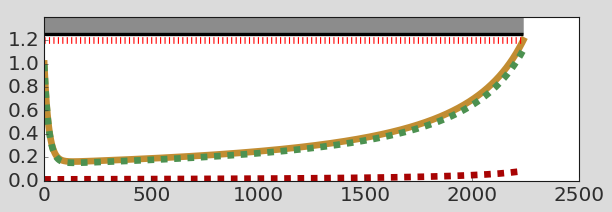

In [8]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']

model = StemCellModel2(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.05, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

# plt.savefig("figures/figSI_SC_AT.pdf")

In [9]:
def synthetic_R_pop(t, beta, rR, N_star, N0, R0, **kwargs):
    return R0 / (1 - beta * rR * (2 * R0 / (N_star + N0)) * t)

def synthetic_S_pop(t, beta, rR, N_star, N0, R0, **kwargs):
    bracket = 1 - beta * rR * t * (2 * R0 / (N_star + N0))
    return N0 * (1 - np.log(bracket) / beta)


Mean TTP for Stem Cell Model under Continuous Therapy is 28 days


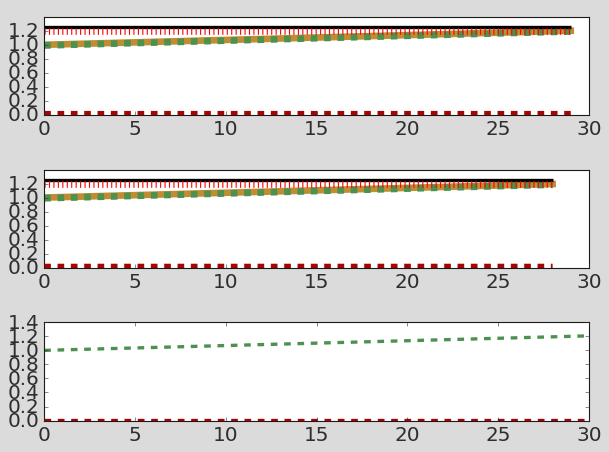

In [10]:
fig, axs = plt.subplots(3,1,figsize=(8,6))
stemParamDic = stemParamDic14
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']

palette = {'TumourSize': colors["CT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}

for i, modelclass in enumerate([StemCellModel, StemCellModel2]):
    model = modelclass(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    # model.Simulate([[0, 3000, 1]])
    model.Simulate_AT(atThreshold=2, intervalLength=1, t_end=10000)
    # model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]
    
    PlotSimulation(model.resultsDf, ax=axs[i], legend=False, colors = palette, linewidth = 6)

t_span = np.linspace(0, axs[1].get_xlim(), 100) 
axs[2].plot(t_span, synthetic_R_pop(t_span, N_star=stemParamDic['N0'], **stemParamDic)/stemParamDic['N0'], color=colors['Resistant'], linestyle='--', linewidth=3)
axs[2].plot(t_span, synthetic_S_pop(t_span, N_star=stemParamDic['N0'], **stemParamDic)/stemParamDic['N0'], color=colors['Sensitive'], linestyle='--', linewidth=3)

print(f"Mean TTP for Stem Cell Model under Continuous Therapy is {max(model.resultsDf.Time):.0f} days")


In [11]:
# Can the analytic expression predict the progression threshold from the initial size and growth time
# Does the solver then correctly extract this time given the progression threshold and initial size?

print(synthetic_S_pop(30, N_star=stemParamDic['N0'], **stemParamDic) / stemParamDic['N0'])

1.2067913514889557


In [12]:
from scipy.optimize import fsolve

def N_star_wrapper(N_star):
    return N_star_function(N_star, tau=30, **stemParamDic)

def N_star_function(N_star, tau, rR, beta, R0, N0,  **_args):
    bracket = 1 - beta * rR * tau * (2 * R0 / (N_star + N0))
    print(bracket)
    return 1.2 * N0 - N_star * (1 - np.log(bracket) / beta)


N_star_initial_guess = stemParamDic['N0']
N_star_solution = fsolve(N_star_wrapper, N_star_initial_guess)
print(N_star_solution)

[0.99124987]
[0.99124987]
[0.99124987]
[0.99124987]
[0.99122285]
[0.99122286]
[0.99122286]
[1003.78272578]


Mean TTP for Stem Cell Model under Adaptive Therapy is 2125 days


(0.0, 2500.0)

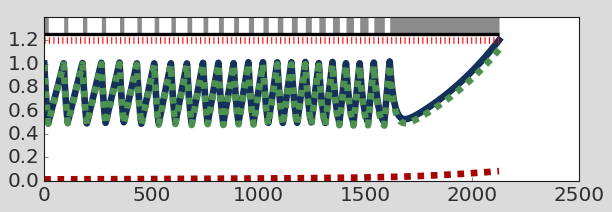

In [13]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

ax.set_xlim(0, 2500)

Mean TTP for Stem Cell Model under Adaptive Therapy is 2238 days


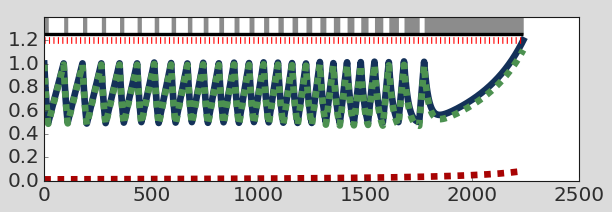

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,3))

model = StemCellModel2(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)

Mean TTP for Stem Cell Model under Adaptive Therapy is 833 days


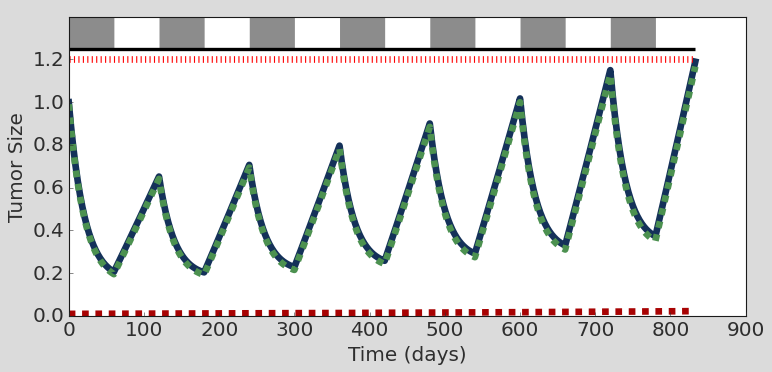

In [15]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.6, atMethod='Threshold',
                    intervalLength=60, t_end=1500, refSize = stemParamDic['N0'])
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

print(f"Mean TTP for Stem Cell Model under Adaptive Therapy is {max(model.resultsDf.Time):.0f} days")

plt.xlabel("Time (days)"); plt.ylabel("Tumor Size")
palette = {'TumourSize': colors["AT"], 'S': colors['Sensitive'], 'R': colors['Resistant']}
PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
plt.savefig("../figures/stem_cell_model_progression_example")

In [16]:
def calc_ttp(params, n_crit, interval):
    model = StemCellModel(method='Radau', dt = 1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=n_crit, atMethod='Threshold',
                    intervalLength=interval, t_end=1500, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max()

In [17]:
from scipy.optimize import fsolve

def N_star_wrapper(N_star):
    return N_star_function(N_star, tau=4, **stemParamDic)

def N_star_function(N_star, tau, rR, beta, R0, N0,  **_args):
    bracket = 1 - beta * rR * tau * (2 * R0 / (N_star + N0))
    return 1.2 * N0 - N_star * (1 - np.log(bracket) / beta)


N_star_initial_guess = stemParamDic['N0']
N_star_solution = fsolve(N_star_wrapper, N_star_initial_guess)
print(N_star_solution / stemParamDic['N0'])

[1.17037773]


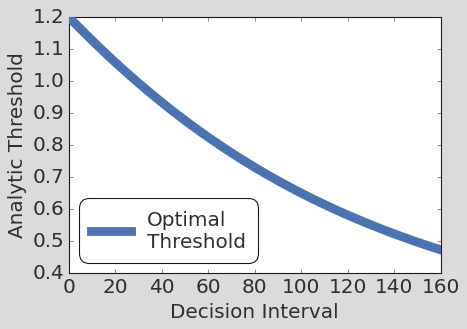

In [18]:
# Plot these, normalising the tumour size by the initial size
fig, ax = plt.subplots(1,1,figsize=(6,4))

tau_values = np.linspace(0, 160, 100)

def solver_wrapper(tau, params):
    inner_wrapper = lambda N_star : N_star_function(N_star, tau=tau, **params)
    return fsolve(inner_wrapper, params['N0'])

n_stars = [solver_wrapper(tau=t, params=stemParamDic) / stemParamDic['N0'] for t in tau_values]
ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 


# ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

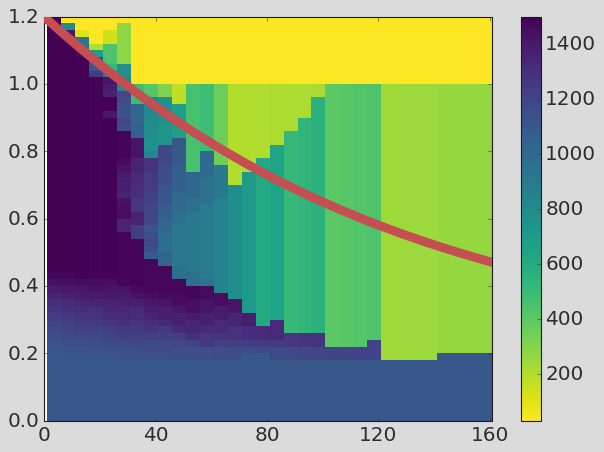

In [16]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator



# make these smaller to increase the resolution
dx, dy = 1, 0.01
dx, dy = 5, 0.02
# dx, dy = 40, 0.4

# generate 2 2d grids for the x & y bounds
crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Optimal\nThreshold'); 

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_ylim(0, np.max(crit_n_grid));
 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/stem_cell_model_threshold"); plt.show()

## Updated Formulation - Exact solution


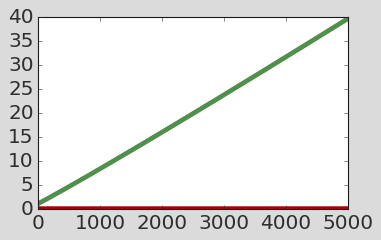

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,3))

model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate([[0, 5000, 0]])
# model.Simulate_AT(atThreshold=0.5, intervalLength=1, t_end=10000)
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])

plt.plot(model.resultsDf.Time, model.resultsDf.TumourSize, color=colors['CT'], linewidth=4)
plt.plot(model.resultsDf.Time, model.resultsDf.S, color=colors['Sensitive'], linewidth=4)
plt.plot(model.resultsDf.Time, model.resultsDf.R, color=colors['Resistant'], linewidth=4)

Okay so this does look pretty linear. But can we predict the gradient?

In [20]:
print(stemParamDic)

{'rR': 0.6931471805599453, 'beta': 0.0425, 'dR': 0.0478, 'rho': 0, 'phi': 0, 'DMax': 1, 'S0': 1000, 'R0': 10, 'P0': 0, 'N0': 1010}


Final y value is 39.57681285


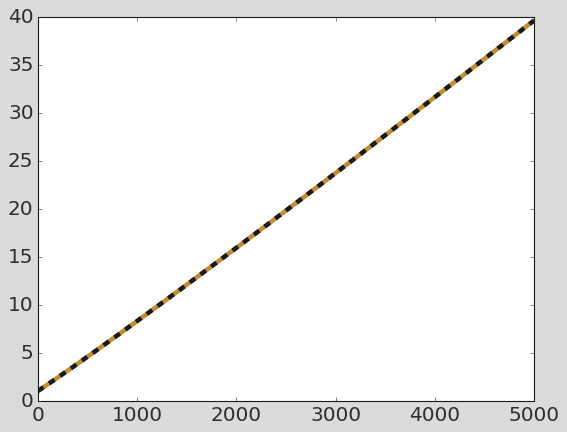

In [21]:
def predict_Nt(t, beta, rR, N0, R0, **kwargs):
    return ((rR * (1 - beta) * R0 * t) / (N0 ** beta) + N0 ** (1-beta) ) ** (1 / (1-beta))

# def simple_predict_Nt(t, beta, rR, N0, R0, **kwargs):
#     return N0 + rR * R0 / (N0 ** beta) * t

y_vals = [predict_Nt(t, **stemParamDic) / stemParamDic['N0'] for t in model.resultsDf.Time.values]
print(f"Final y value is {y_vals[-1]:.8f}")

plt.plot(model.resultsDf.Time, model.resultsDf.TumourSize, color=colors['CT'], linewidth=4)
plt.plot(model.resultsDf.Time, y_vals, color='k', linestyle='--', linewidth=4);

Final y value is 39.57681285


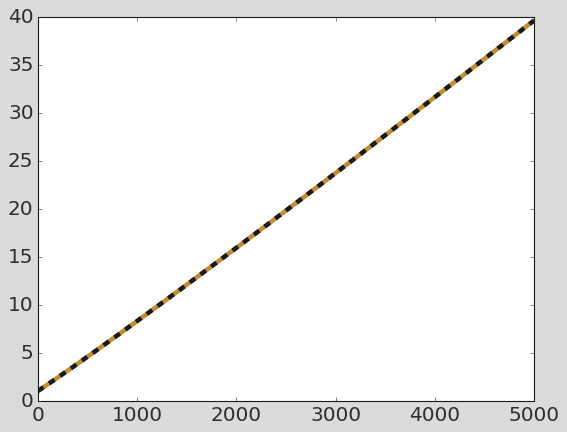

In [22]:
# To check - we can also predict the tumour size from the R population directly

def predict_Nt(R, beta, N0, R0, **kwargs):
    # print((1/ R0) ** (1 / beta))
    return N0 * (R/ R0) ** (1 / beta)

y_vals = [predict_Nt(R , **stemParamDic) / stemParamDic['N0'] for R in model.resultsDf.R.values * stemParamDic['N0'] ]
print(f"Final y value is {y_vals[-1]:.8f}")

# plt.ylim(0, 10)


plt.plot(model.resultsDf.Time, model.resultsDf.TumourSize, color=colors['CT'], linewidth=4)
plt.plot(model.resultsDf.Time, y_vals, color='k', linestyle='--', linewidth=4);

### Use the new approach for map

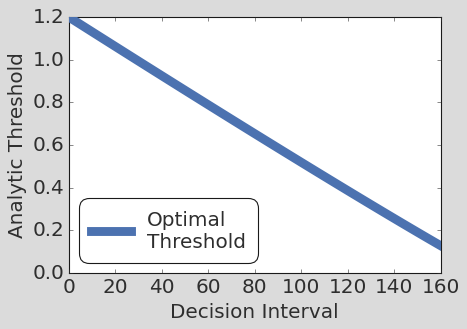

In [23]:
def predict_N_star(tau, beta, rR, N0, R0, **kwargs):
    return ((1.2 * N0) ** (1-beta) -  (rR * (1 - beta) * R0 * tau) / (N0 ** beta) ) ** (1 / (1-beta))

# Plot these, normalising the tumour size by the initial size
fig, ax = plt.subplots(1,1,figsize=(6,4))

new_n_stars = [predict_N_star(tau=t, **stemParamDic) / stemParamDic['N0'] for t in tau_values]
ax.plot(tau_values, new_n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 


# ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

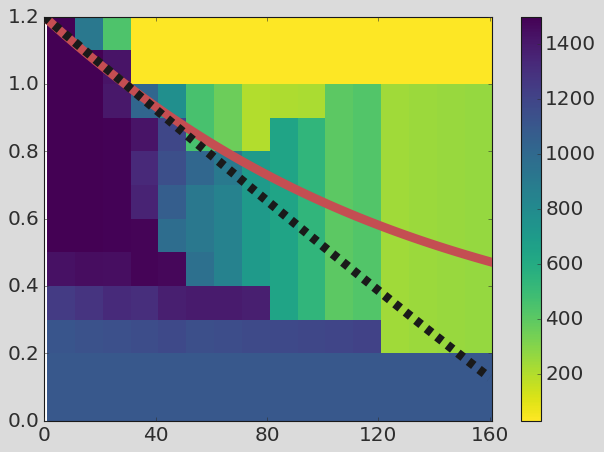

In [22]:
dx, dy = 1, 0.01
dx, dy = 10, 0.1
# dx, dy = 40, 0.4

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Approx\nThreshold'); 
ax.plot(tau_values, new_n_stars, linewidth = 8, zorder=5, color='k', linestyle='--', label = 'Exact\nThreshold');

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_ylim(0, np.max(crit_n_grid));
 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/stem_cell_model_threshold2"); plt.show()


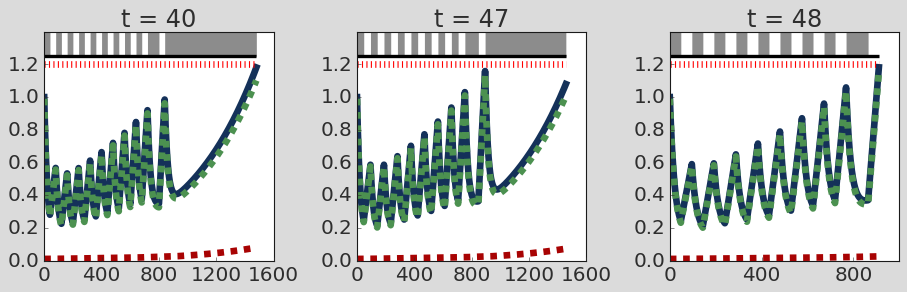

In [24]:
fig, axs = plt.subplots(1, 3,figsize=(12,4))

interval_lengths = [40, 47, 48]

for n, ax in enumerate(axs):
    stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
    model = StemCellModel(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    model.Simulate_AT(atThreshold=0.4, atMethod='Threshold', t_end=1500,
                        intervalLength=interval_lengths[n], refSize = stemParamDic['N0'])
    model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

    PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
    ax.set_xticks(ax.get_xticks()[::2]); ax.set_title(f"t = {interval_lengths[n]}")


This doesn't account for growing population of stem cells. It computes the growth in tau time at the start of treatment only. 

When writing this down, we have adjusted the initial conditions of one integral (N over t) to reflect the new starting position, but not the original integral (N over S). In effect, the constant of integration B needs to be time dependent, based on the stem-cell population at that point in time.

We can't compute this exactly, as it depends on the treatment history. But perhaps we can use the previous method for approximating this growth?

## Approach 3

In [25]:
def updated_predict_N_star(tau, t, beta, rR, N0, R0, **kwargs):
    ave_n = (N0 + (1.2 * N0)) / 2
    Rt = R0 / (1 - beta * rR * (R0 / ave_n) * t)
    B_const = (N0 ** beta) / Rt
    return ((1.2 * N0) ** (1-beta) -  (rR * (1 - beta) * tau) / B_const ) ** (1 / (1-beta))

/tmp/ipykernel_205116/93238832.py:5: RuntimeWarning: invalid value encountered in scalar power
  return ((1.2 * N0) ** (1-beta) -  (rR * (1 - beta) * tau) / B_const ) ** (1 / (1-beta))


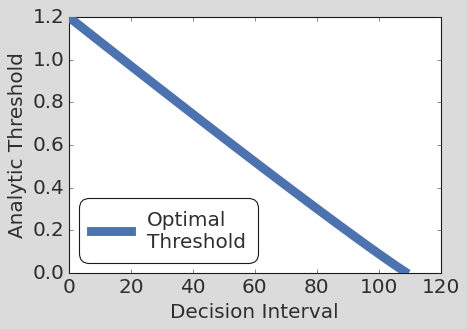

In [26]:

fig, ax = plt.subplots(1,1,figsize=(6,4))

updated_n_stars = [updated_predict_N_star(t=1500, tau=tau, **stemParamDic) / stemParamDic['N0'] for tau in tau_values]
ax.plot(tau_values, updated_n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 


# ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

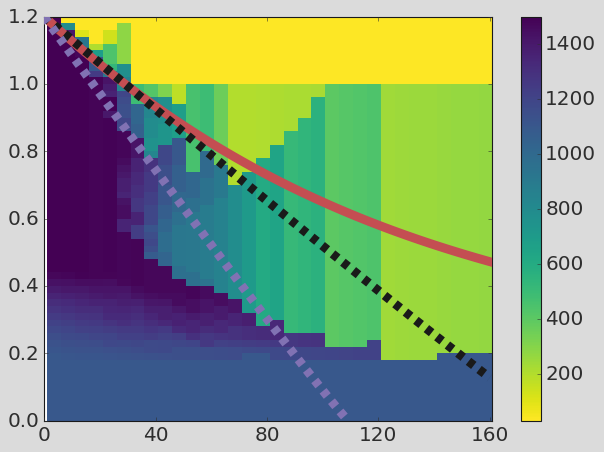

In [26]:
dx, dy = 1, 0.01
dx, dy = 5, 0.02
# dx, dy = 40, 0.4

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Approx\nThreshold'); 
ax.plot(tau_values, new_n_stars, linewidth = 8, zorder=5, color='k', linestyle='--', label = 'New\nThreshold');
ax.plot(tau_values, updated_n_stars, linewidth = 8, zorder=5, color='m', linestyle='--', label = 'Updated\nThreshold');

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_ylim(0, np.max(crit_n_grid));
 
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/stem_cell_model_threshold3"); plt.show()


To improve accuracy, use the S(t) at the TTP? Or better still, update it over time (using the mean of first and last time for each cycle.)

At the moment we are using the stem population at a fixed time (1000 days) which should underestimate the N_star value when the TTp is much less than this. This explains success beyond the critical threshold, but not premature progression before the threshold.

## Check the accuracy of the S prediction

In [27]:
def calc_stem_cell_pop(t, R0, beta, rR, N0, **kwargs):
    denominator = 1 - beta * rR * t * (R0 / (1.0 * N0))
    return R0 / denominator

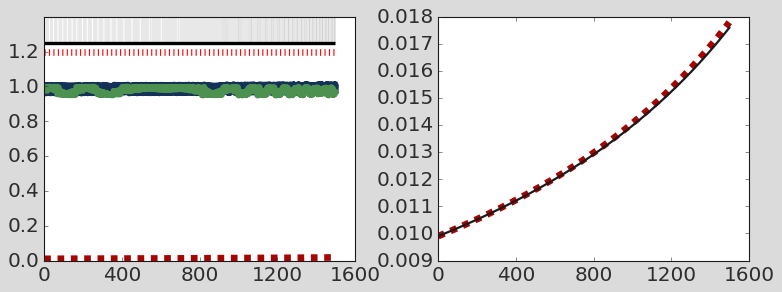

In [28]:
# Stem cell population only prediction
fig, axs = plt.subplots(1, 2,figsize=(10,4))

interval_lengths = [40, 47, 48]

stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=1, atMethod='Threshold', t_end=1500,
                    intervalLength=1, refSize = stemParamDic['N0'])
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

PlotSimulation(model.resultsDf, ax=axs[0], legend=False, colors = palette, linewidth = 6)

axs[1].plot(model.resultsDf.Time, model.resultsDf.R, color=colors['Resistant'], linewidth=6, linestyle='--')

predicted_St = [calc_stem_cell_pop(t, **stemParamDic) / stemParamDic['N0'] for t in model.resultsDf.Time.values]
axs[1].plot(model.resultsDf.Time, predicted_St, color='k', linewidth=2)

axs[0].set_xticks(axs[0].get_xticks()[::2]); axs[1].set_xticks(axs[1].get_xticks()[::2]);

## Debug the specific date intervals that fail left of the curve above

In [29]:
print(stemParamDic)

{'rR': 0.6931471805599453, 'beta': 0.0425, 'dR': 0.0478, 'rho': 0, 'phi': 0, 'DMax': 1, 'S0': 1000, 'R0': 10, 'P0': 0, 'N0': 1010}


Final Stem Cell population is 0.0806, drug state is 1
Final Stem Cell population is 0.0805, drug state is 1
Final Stem Cell population is 0.0319, drug state is 0


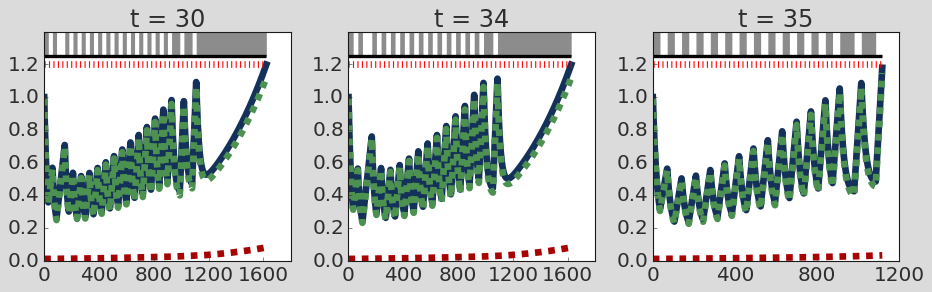

In [30]:
fig, axs = plt.subplots(1, 3,figsize=(12,4))

interval_lengths = [30, 34, 35]

for n, ax in enumerate(axs):
    stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
    model = StemCellModel(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    model.Simulate_AT(atThreshold=0.5, atMethod='Threshold', t_end=2000,
                        intervalLength=interval_lengths[n], refSize = stemParamDic['N0'])
    model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

    PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
    ax.set_xticks(ax.get_xticks()[::2]); ax.set_title(f"t = {interval_lengths[n]}")

    print(f"Final Stem Cell population is {model.resultsDf.R.values[-1]:.4f}"
          + f", drug state is {model.resultsDf.DrugConcentration.values[-1]:.0f}")


I think we are underestimating the normal population during the simulation. This is essential to accurately predict the sensitive population. As a worst case - lets just use the N* and not the average between N* and progression.

## Approach 4

In [31]:
def conservative_predict_N_star(tau, t, beta, rR, N0, R0, **kwargs):
    ave_n = (N0) / 2
    Rt = R0 / (1 - beta * rR * (R0 / ave_n) * t)
    B_const = (N0 ** beta) / Rt
    return ((1.2 * N0) ** (1-beta) -  (rR * (1 - beta) * tau) / B_const ) ** (1 / (1-beta))

/tmp/ipykernel_205116/961014628.py:5: RuntimeWarning: invalid value encountered in scalar power
  return ((1.2 * N0) ** (1-beta) -  (rR * (1 - beta) * tau) / B_const ) ** (1 / (1-beta))


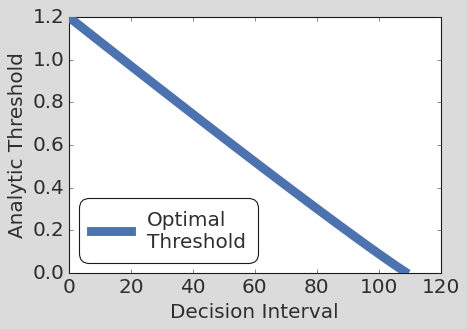

In [32]:

fig, ax = plt.subplots(1,1,figsize=(6,4))

conservative_n_stars = [conservative_predict_N_star(t=1500, tau=tau, **stemParamDic) / stemParamDic['N0'] for tau in tau_values]
ax.plot(tau_values, updated_n_stars, linewidth = 8, zorder=5, label = 'Optimal\nThreshold'); 


# ax.set_ylim(-0.01,1.23); ax.tick_params(right = False, top = False)
plt.gca().legend(loc=3, fontsize=18, numpoints=1, borderaxespad=0.7).get_frame().set_boxstyle('Round', pad=0.2, rounding_size=0.5)
plt.xlabel("Decision Interval"); plt.ylabel("Analytic Threshold");

In [33]:
dx, dy = 1, 0.01
dx, dy = 5, 0.02
# dx, dy = 40, 0.4

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.2 + dy, dy),
                slice(1, 161 + dx, dx)]


vectorized_calc_ttp = np.vectorize(calc_ttp)
ttp_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
fig, ax = plt.subplots()

im = ax.pcolormesh(tau_grid, crit_n_grid, ttp_values, 
                   cmap=plt.get_cmap('viridis_r'), norm=None)
fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='r', label = 'Approx\nThreshold'); 
ax.plot(tau_values, new_n_stars, linewidth = 8, zorder=5, color='k', linestyle='--', label = 'New\nThreshold');
ax.plot(tau_values, updated_n_stars, linewidth = 8, zorder=5, color='m', linestyle='--', label = 'Updated\nThreshold');
ax.plot(tau_values, conservative_n_stars, linewidth = 8, zorder=5, color='c', linestyle='--', label = 'Conservative\nThreshold');

ax.set_xlim(0, np.max(tau_grid)); 
ax.set_ylim(0, np.max(crit_n_grid));
 
ax.set_xticks(ax.get_xticks()[::2]); fig, axs = plt.subplots(1, 3,figsize=(12,4))

interval_lengths = [30, 34, 35]

for n, ax in enumerate(axs):
    stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
    model = StemCellModel(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    model.Simulate_AT(atThreshold=0.5, atMethod='Threshold', t_end=2000,
                        intervalLength=interval_lengths[n], refSize = stemParamDic['N0'])
    model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

    PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
    ax.set_xticks(ax.get_xticks()[::2]); ax.set_title(f"t = {interval_lengths[n]}")

    print(f"Final Stem Cell population is {model.resultsDf.R.values[-1]:.4f}"
          + f", drug state is {model.resultsDf.DrugConcentration.values[-1]:.0f}")


KeyboardInterrupt: 

Can we do anything to estimate overshooting? We should be able to solve the behavior under drug exactly as well?
Or just cheat on this one, as this isn't a clinical paper, and use the current S(t) to work out the optimal threshold....

If we can analytically evaluate stem cell growth on and off treatement (based on the measurable total size) then this is enough of an argument to say this would work in principle, even if we practically just measure S(t)

We can then plot examples of a dynamic treatment trajectory, but still need to work out when the prior approach fails? When the dynamic threshold exceeds the fixed threshold during treatment?

Final Stem Cell population is 0.0806, drug state is 1
Final Stem Cell population is 0.0806, drug state is 1
Final Stem Cell population is 0.0255, drug state is 0


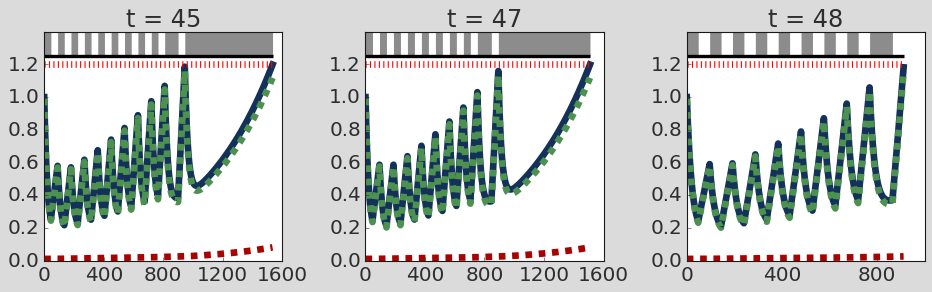

In [34]:
fig, axs = plt.subplots(1, 3,figsize=(12,4))

interval_lengths = [45, 47, 48]

for n, ax in enumerate(axs):
    stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
    model = StemCellModel(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    model.Simulate_AT(atThreshold=0.4, atMethod='Threshold', t_end=2000,
                        intervalLength=interval_lengths[n], refSize = stemParamDic['N0'])
    model.Trim(dt=1)
    model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

    PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
    ax.set_xticks(ax.get_xticks()[::2]); ax.set_title(f"t = {interval_lengths[n]}")

    print(f"Final Stem Cell population is {model.resultsDf.R.values[-1]:.4f}"
          + f", drug state is {model.resultsDf.DrugConcentration.values[-1]:.0f}")

plt.tight_layout(); 
# plt.savefig("../figures/stem_cell_model_progression_example2"); plt.show()

In [35]:
from scipy.optimize import fsolve

def N_star_function(N_star, tau, Rt, beta, rR, prog, **_args):
    frac = rR * (1 - beta) * Rt * tau / (N_star ** beta)
    return frac + N_star ** (1-beta) - prog ** (1-beta)


In [ ]:
import warnings
warnings.simplefilter('error', RuntimeWarning)

prog = stemParamDic['N0'] * 1.2

def compute_threshold(tau, t, R_t, params):
    def N_star_wrapper(N_star):
        return N_star_function(N_star, tau=tau, Rt=R_t, prog=prog, **params)
    
    try:
        value = fsolve(N_star_wrapper, params['N0'])[0]
        print(f"Value is {value}")
        return value
    except RuntimeWarning:
        print(f"Failed at {tau}")
        return 0
    

In [40]:
tau = 55
def variable_threshold(df_row, refSize, t):
    threshold = compute_threshold(tau, t, df_row.R, stemParamDic)
    if threshold == 0 or np.isnan(threshold):
        print("Threshold is zero " + str(threshold))
        return 0
    return df_row.TumourSize > threshold 

Value is 809.9619282023348
Value is 791.3985407746819
Value is 782.0097987709615
Value is 761.4967867399093
Value is 740.3147701849745
Value is 729.6806657037687
Value is 706.5189717632445
Value is 682.6359130867422
Value is 648.660251725827
Value is 619.4956335249481
Value is 580.2512484379349
Value is 547.083676229375
Value is 502.5505945683503
Value is 464.85058904050516
Value is 414.0354189599012
Value is 370.7597488652228
Value is 311.85714839585614
Value is 201.20696382949703
Threshold is zero 0
Threshold is zero 0
Value is 827.4709921761336
Value is 827.3552225546041
Value is 827.2346349205889
Value is 827.1090650550115
Value is 826.9783461380683
Value is 826.8423089618725
Value is 826.7007821627648
Value is 826.5535924760134
Value is 826.4005650130993
Value is 826.2415235616404
Value is 826.0762909078071
Value is 825.904689180894
Value is 825.7265402194996
Value is 825.5416659585411
Value is 825.3498888360878
Value is 825.1510322187656
Value is 824.9449208442182
Value is 824.73

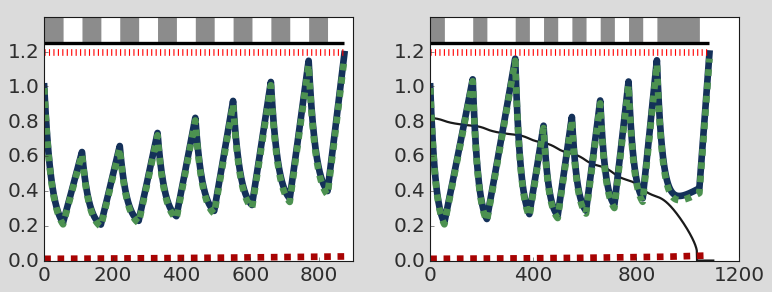

In [41]:
fig, axs = plt.subplots(1, 2,figsize=(10,4))

# Simulate model with fixed threshold
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.4, atMethod='Threshold', t_end=1500,
                    intervalLength=tau, refSize = stemParamDic['N0'])
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

PlotSimulation(model.resultsDf, ax=axs[0], legend=False, colors = palette, linewidth = 6)

# Simulate model with time varying threshold
stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.4, atMethod='Custom', atFunc=variable_threshold, t_end=1500,
                    intervalLength=tau, refSize = stemParamDic['N0'])
model.Trim(dt=1)

# Plot the variable threshold over time
threshold_vals = [compute_threshold(tau=tau, t=t, R_t=R_t, params=stemParamDic) / stemParamDic['N0'] 
                  for t, R_t in zip(model.resultsDf.Time.values, model.resultsDf.R.values)]
axs[1].plot(model.resultsDf.Time, threshold_vals, color='k', linewidth=2)

model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

PlotSimulation(model.resultsDf, ax=axs[1], legend=False, colors = palette, linewidth = 6)



axs[0].set_xticks(axs[0].get_xticks()[::2]); axs[1].set_xticks(axs[1].get_xticks()[::2]);

In [ ]:
tau = 25
def variable_threshold(df_row, refSize, t):
    threshold = compute_threshold(tau, t, df_row.R, stemParamDic)
    if threshold == 0 or np.isnan(threshold):
        print("Threshold is zero " + str(threshold))
        return 0
    return df_row.TumourSize > threshold 

Threshold is zero 0
Threshold is zero 0


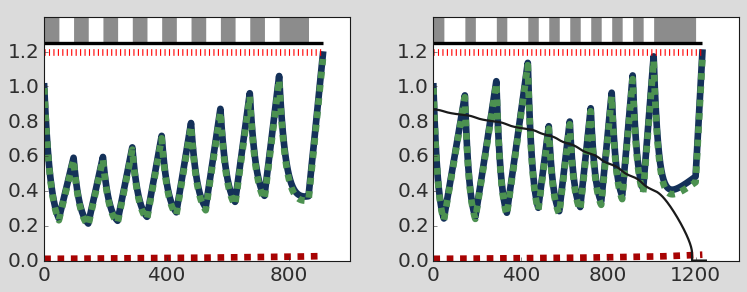

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(10,4))


stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.4, atMethod='Threshold', t_end=2000,
                    intervalLength=tau, refSize = stemParamDic['N0'])
model.Trim(dt=1)
model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

PlotSimulation(model.resultsDf, ax=axs[0], legend=False, colors = palette, linewidth = 6)

stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
model = StemCellModel(method='Radau', dt = 1)
model.SetParams(**stemParamDic)
model.Simulate_AT(atThreshold=0.4, atMethod='Custom', atFunc=variable_threshold, t_end=2500,
                    intervalLength=tau, refSize = stemParamDic['N0'])
model.Trim(dt=1)

threshold_vals = [compute_threshold(tau=tau, t=t, R_t=R_t, params=stemParamDic) / stemParamDic['N0'] 
                  for t, R_t in zip(model.resultsDf.Time.values, model.resultsDf.R.values)]
axs[1].plot(model.resultsDf.Time, threshold_vals, color='k', linewidth=2, zorder=10)

model.resultsDf[['TumourSize', 'S', 'R']] /= (stemParamDic['S0'] + stemParamDic['R0'])
model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

PlotSimulation(model.resultsDf, ax=axs[1], legend=False, colors = palette, linewidth = 6)



axs[0].set_xticks(axs[0].get_xticks()[::2]); axs[1].set_xticks(axs[1].get_xticks()[::2]);

How do we turn  this into a limiting line on a grid?

We could simulate each case and then determine whether the threshold used was ever under the line??

Final Stem Cell population is 0.0806, drug state is 1, and predicted failure is True
Final Stem Cell population is 0.0806, drug state is 1, and predicted failure is False
Final Stem Cell population is 0.0255, drug state is 0, and predicted failure is True


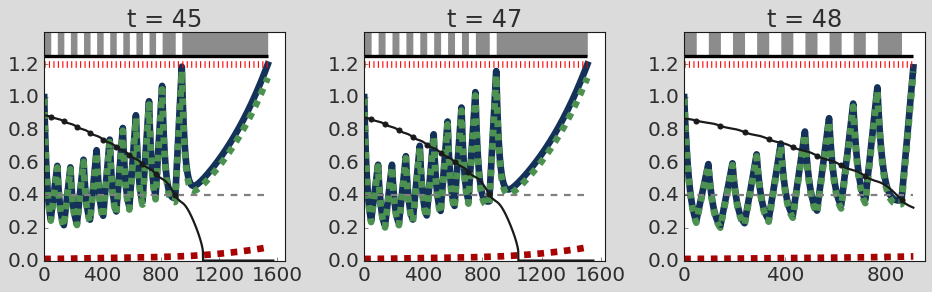

In [ ]:
fig, axs = plt.subplots(1, 3,figsize=(12,4))

interval_lengths = [45, 47, 48]

for n, ax in enumerate(axs):
    stemParamDic['N0'] = stemParamDic['S0'] + stemParamDic['R0']
    model = StemCellModel(method='Radau', dt = 1)
    model.SetParams(**stemParamDic)
    model.Simulate_AT(atThreshold=0.4, atMethod='Threshold', t_end=2000,
                        intervalLength=interval_lengths[n], refSize = stemParamDic['N0'])
    model.Trim(dt=1)

    threshold_vals = [compute_threshold(tau=interval_lengths[n], t=t, R_t=R_t, 
                                        params=stemParamDic) / stemParamDic['N0'] 
                  for t, R_t in zip(model.resultsDf.Time.values, model.resultsDf.R.values)]
    ax.plot(model.resultsDf.Time, threshold_vals, color='k', linewidth=2, zorder=10)

    N_init = (stemParamDic['S0'] + stemParamDic['R0'])
    model.resultsDf[['TumourSize', 'S', 'R']] /= N_init
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2]

    PlotSimulation(model.resultsDf, ax=ax, legend=False, colors = palette, linewidth = 6)
    ax.set_xticks(ax.get_xticks()[::2]); ax.set_title(f"t = {interval_lengths[n]}")

    ax.hlines(0.4, xmin=0, xmax=model.resultsDf.Time.max(),
            color='gray', linestyle='--', linewidth=2)
    
    time_points = model.resultsDf[(model.resultsDf.Time % interval_lengths[n] == 0)
                                  & (model.resultsDf.DrugConcentration == 0)].Time.tolist()
    threshold_points = [compute_threshold(tau=interval_lengths[n], t=t, R_t=R_t * N_init, 
                                        params=stemParamDic) / stemParamDic['N0'] 
                  for t, R_t in zip(time_points, model.resultsDf[model.resultsDf.Time.isin(time_points)].R.values)]
    ax.scatter(time_points, threshold_points, color='k', s=20, zorder=10)
    failure = any(val < 0.4 for val in threshold_points)
        
    print(f"Final Stem Cell population is {model.resultsDf.R.values[-1]:.4f}"
          + f", drug state is {model.resultsDf.DrugConcentration.values[-1]:.0f}"
          + f", and predicted failure is {failure}")
    ax.set_xlim(left=0)

# print(time_points)
# print(threshold_points)
# model.resultsDf.to_csv("test_results.csv")

plt.tight_layout(); 
# plt.savefig("../figures/stem_cell_model_progression_example2"); plt.show()

I think this prediction metric is right. It correctly predicts that t=45 is at risk of premature progression, however going into the data we find that the overshoot below the 0.4 threshold meant they didn't reach the progression threshold in the next period.

Will go forwards with this metric, which reflects what we want it to, but we could also update to consider growth from actual current size rather than the official threshold

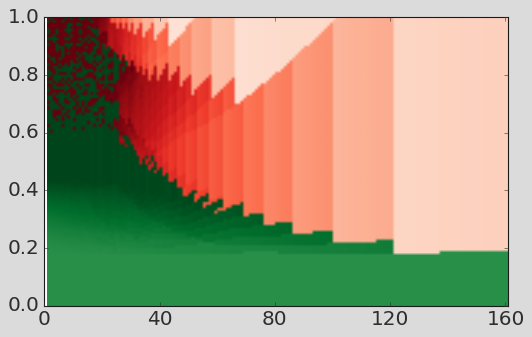

In [175]:
def calc_result(params, n_crit, interval):
    model = StemCellModel(method='Radau', dt = 1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=n_crit, atMethod='Threshold',
                    intervalLength=interval, t_end=1500, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]
    return model.resultsDf.Time.max(), int(model.resultsDf.DrugConcentration.iloc[-1] > 0)

dx, dy = 1, 0.01


crit_n_grid, tau_grid = np.mgrid[slice(0, 1.0 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_result)
ttp_values, drug_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
drug_values = drug_values[:-1, :-1]

# Create custom colormap
cmap_red = plt.get_cmap('Reds')
cmap_green = plt.get_cmap('Greens')

cmap_combined = np.zeros((ttp_values.shape[0], ttp_values.shape[1], 3))
for i in range(ttp_values.shape[0]):
    for j in range(ttp_values.shape[1]):
        if drug_values[i, j] == 1:
            cmap_combined[i, j, :] = cmap_green(ttp_values[i, j] / np.max(ttp_values))[:3]
        else:
            cmap_combined[i, j, :] = cmap_red(ttp_values[i, j] / np.max(ttp_values))[:3]

fig, ax = plt.subplots(figsize=(7, 5))

# ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='k', label = 'Optimal\nThreshold'); 

im = ax.imshow(cmap_combined, origin='lower', extent=[tau_grid.min(), tau_grid.max(), crit_n_grid.min(), crit_n_grid.max()])
# fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.set_xlim(tau_grid.min(), tau_grid.max())
ax.set_ylim(crit_n_grid.min(), crit_n_grid.max())
ax.set_aspect(100)
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/stem_cell_model_threshold_binary.pdf"); plt.show()

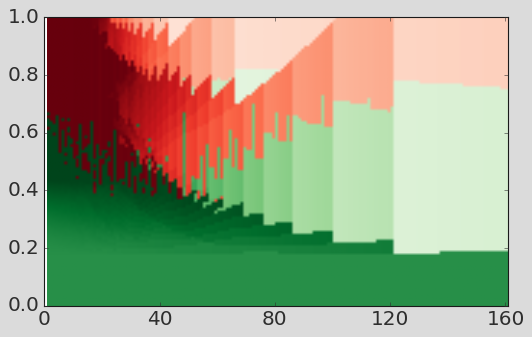

In [176]:
def calc_result(params, n_crit, interval):
    model = StemCellModel(method='Radau', dt = 1); model.SetParams(**params)
    model.Simulate_AT(atThreshold=n_crit, atMethod='Threshold',
                    intervalLength=interval, t_end=1500, refSize = params['N0'])
    model.resultsDf = model.resultsDf[model.resultsDf.TumourSize < 1.2 * params['N0']]

    time_points = model.resultsDf[(model.resultsDf.Time % interval_lengths[n] == 0)
                                  & (model.resultsDf.DrugConcentration == 0)].Time.tolist()
    threshold_points = [compute_threshold(tau=interval_lengths[n], t=t, R_t=R_t, 
                                        params=stemParamDic) / stemParamDic['N0'] 
                  for t, R_t in zip(time_points, model.resultsDf[model.resultsDf.Time.isin(time_points)].R.values)]
    failure = any(val < n_crit for val in threshold_points)

    return model.resultsDf.Time.max(), int(failure)

dx, dy = 2, 0.02
dx, dy = 1, 0.01

crit_n_grid, tau_grid = np.mgrid[slice(0, 1.0 + dy, dy),
                slice(1, 161 + dx, dx)]

vectorized_calc_ttp = np.vectorize(calc_result)
ttp_values, outcome_values = vectorized_calc_ttp(
    params = stemParamDic, n_crit = crit_n_grid,
    interval = tau_grid
)

ttp_values = ttp_values[:-1, :-1]
outcome_values = outcome_values[:-1, :-1]

# Create custom colormap
cmap_red = plt.get_cmap('Reds')
cmap_green = plt.get_cmap('Greens')

cmap_combined = np.zeros((ttp_values.shape[0], ttp_values.shape[1], 3))
for i in range(ttp_values.shape[0]):
    for j in range(ttp_values.shape[1]):
        if outcome_values[i, j] == 0:
            cmap_combined[i, j, :] = cmap_green(ttp_values[i, j] / np.max(ttp_values))[:3]
        else:
            cmap_combined[i, j, :] = cmap_red(ttp_values[i, j] / np.max(ttp_values))[:3]

fig, ax = plt.subplots(figsize=(7, 5))

# ax.plot(tau_values, n_stars, linewidth = 8, zorder=5, color='k', label = 'Optimal\nThreshold'); 

im = ax.imshow(cmap_combined, origin='lower', extent=[tau_grid.min(), tau_grid.max(), crit_n_grid.min(), crit_n_grid.max()])
# fig.colorbar(im, ax=ax); #ax.set_title('TTP of Patient 25')

ax.set_xlim(tau_grid.min(), tau_grid.max())
ax.set_ylim(crit_n_grid.min(), crit_n_grid.max())
ax.set_aspect(100)
ax.set_xticks(ax.get_xticks()[::2]); 
fig.tight_layout(); 
plt.savefig("../figures/stem_cell_model_threshold_binary2.pdf"); plt.show()

In [108]:
def predict_Nt(t, beta, rR, N0, R0, **kwargs):
    return ((rR * (1 - beta) * R0 * t) / (N0 ** beta) + N0 ** (1-beta) ) ** (1 / (1-beta))

In [109]:
def compute_threshold(tau, t, R_t, R0, beta, rR, N0, prog, **kwargs):
    B_t = (N0 ** beta) / R_t
    value = ((prog) ** (1-beta) -  (rR * (1 - beta) * tau) / B_t ) ** (1 / (1-beta))
    return value

In [111]:
# Validate the N(t) prediction against simulated data

print(predict_Nt(25, **stemParamDic))

# Compare to actual growth
test_model = StemCellModel(method='Radau', dt = 1)
test_model.SetParams(**stemParamDic)
test_model.Simulate([[0, 25, 0]])
print(test_model.resultsDf.tail())

1183.8879407350162
    Time  DrugConcentration            S          R    P   TumourSize
21  21.0                0.0  1145.930780  10.057542  0.0  1155.988322
22  22.0                0.0  1152.900458  10.060113  0.0  1162.960571
23  23.0                0.0  1159.871927  10.062670  0.0  1169.934597
24  24.0                0.0  1166.845178  10.065212  0.0  1176.910390
25  25.0                0.0  1173.820200  10.067741  0.0  1183.887941


In [113]:
# Predict the initial threshold at time zero and compare to progression limit

print(compute_threshold(tau=25, t=0, R_t=stemParamDic['R0'],
                        prog = stemParamDic['N0'] * 1.2, **stemParamDic))

print(stemParamDic['N0'] * 1.2)


1037.9251829651726
1212.0


In [114]:
# So if we reduce the whole tumor size to threshold we should reach progression in 25 days:
test_params = stemParamDic.copy()
test_params['N0'] = 1037.9251829651726
test_params['S0'] = test_params['N0'] - test_params['R0']

test_model = StemCellModel(method='Radau', dt = 1)
test_model.SetParams(**test_params)
test_model.Simulate([[0, 25, 0]])
print(test_model.resultsDf.tail())

    Time  DrugConcentration            S          R    P   TumourSize
21  21.0                0.0  1173.846375  10.056083  0.0  1183.902458
22  22.0                0.0  1180.815081  10.058593  0.0  1190.873674
23  23.0                0.0  1187.785537  10.061089  0.0  1197.846626
24  24.0                0.0  1194.757731  10.063572  0.0  1204.821302
25  25.0                0.0  1201.731654  10.066042  0.0  1211.797696


In [116]:
# This is pretty close! But what if we add the correction and solve numerically...

from scipy.optimize import fsolve

prog = stemParamDic['N0'] * 1.2

def N_star_wrapper(N_star):
    return N_star_function(N_star, tau=25, prog=prog, **test_params)

def N_star_function(N_star, tau, R0, beta, rR, prog, **_args):
    frac = rR * (1 - beta) * R0 * tau / (N_star ** beta)
    return frac + N_star ** (1-beta) - prog ** (1-beta)

N_star_initial_guess = stemParamDic['N0']
N_star_solution = fsolve(N_star_wrapper, N_star_initial_guess)
print(N_star_solution)

[1038.12759626]


In [117]:
# Now lets simulate again from the new initial size
test_params2 = stemParamDic.copy()
test_params2['N0'] = 1038.12759626
test_params2['S0'] = test_params2['N0'] - test_params2['R0']

test_model = StemCellModel(method='Radau', dt = 1)
test_model.SetParams(**test_params2)
test_model.Simulate([[0, 25, 0]])
print(test_model.resultsDf.tail())

# The final size is exactly the progression limit, so we have solved the problem!

    Time  DrugConcentration            S          R    P   TumourSize
21  21.0                0.0  1174.048720  10.056073  0.0  1184.104793
22  22.0                0.0  1181.017420  10.058582  0.0  1191.076002
23  23.0                0.0  1187.987868  10.061078  0.0  1198.048946
24  24.0                0.0  1194.960055  10.063560  0.0  1205.023615
25  25.0                0.0  1201.933970  10.066030  0.0  1212.000000
